# TIME SLOTS DEFINITION

## 1. DATA & SETTINGS

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spln
from sklearn.cluster import KMeans
import utils.metropolishastings as mh
from utils.state import State
import random
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.signal import argrelextrema
from matplotlib.backends.backend_pdf import PdfPages
import random
import math as m
import seaborn as sns
import copy
from cryptography.fernet import Fernet
import warnings
from utils.generate_draws import generate_draws
warnings.filterwarnings("ignore") 
from collections import Counter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Importing file
mtf_tag = pd.read_pickle('data/motifs_mrmt_2015_all_tag_purpose.pkl')

# Adding informations
col_to_use = ['HHNR','gesl','f41610a', 'zivil'] # household, gender, GA, civil status (single, married, widowed, divorced, unmaried, registred part, unpart)

# Read CSV file
ziel = pd.read_csv('data/zielpersonen.csv', sep=',', decimal=".", encoding='ISO-8859-1', usecols=col_to_use)

# Rename columns
ziel.rename(columns={'gesl':'gender', 'f41610a':'GA', 'zivil':'maried'}, inplace=True)

# Merge datasets
mtf_tag = mtf_tag.merge(ziel, on='HHNR', how='left')
mtf_tag = mtf_tag.set_index('HHNR')

mtf_tag.head()

,DiGraph_motif,motif_flat,motif_type,motif_id,alter,tag,employment_status,professional_pos,work_sektor12,work_sektor3,ERWERB,GA,maried,gender
HHNR,,,,,,,,,,,,,,
100010,"(0, 2, 3, 4)","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","0,9,4,0,8,0",99,8,6,-99,-99,-99,-99,3,2,1,2
100021,"(0, 3, 4)","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]","0,4,0,8,0",5,68,6,-99,-99,-99,-99,4,2,2,2
100028,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0",1,61,1,4,1,-99,-99,2,2,2,2
100037,"(0, 4, 3)","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","0,8,4,8,0",99,30,6,-99,-99,-99,-99,4,1,2,2
100049,"(0, 4)","[0.0, 1.0, 1.0, 0.0]","0,8,0,8,0",4,11,6,-99,-99,-99,-99,3,2,1,1


## 2. PREPROCESSING

### 2.1 EXTRACT TIMINGS

In [4]:
%%time

timings_list = []

# Iterate over the mtf_tag DataFrame
for idx, row in mtf_tag.iterrows():
    # Extract attribute data from the DiGraph_motif
    node_attrs = nx.get_node_attributes(row['DiGraph_motif'], 'time')

    # Iterate over each node to calculate the activity duration
    for node, time in node_attrs.items():
        # Extract the start and finish times for each activity of the node
        started_at_list = time['started_at']
        finished_at_list = time['finished_at']
        for i in range(len(started_at_list)):
            started_at = started_at_list[i]
            finished_at = finished_at_list[i]
            duration = finished_at - started_at  # Add activity duration
            activity_type = int(node)

            # Add a new tuple to the "timings_list" list
            timings_list.append((idx, activity_type, started_at, finished_at, duration, row['alter'], row['tag'],
                                 row['ERWERB'], row['motif_type'], row['gender'], row['GA'],
                                 row['maried']))

# Create the "tim_init" DataFrame from the "timings_list" list
tim_init = pd.DataFrame(timings_list, columns=['HHNR', 'activity_type', 'started_at', 'finished_at', 'duration', 'alter', 'tag',
                                               'ERWERB', 'motif_type', 'gender', 'GA', 'maried'])

tim_init = tim_init.sort_values(['HHNR', 'started_at'], ascending=[True, True])

# Mapping to fit with real activity names
column_mapping = {1: 12,
                  5: 2,
                  9: 3,
                  3: 4,
                  7: 5,
                  8: 6,
                  6: 7,
                  4: 8,
                  2: 9,
                  12: 13}

# Apply the mapping to the 'activity_type' column
tim_init['activity_type'] = tim_init['activity_type'].replace(column_mapping)

minutes = 6

# Keep a copy of the DataFrame for later use
tim_full = tim_init.copy()

# Apply conditions as mentioned afterwards
tim_full = tim_full[tim_full["started_at"] < 1440]
tim_full = tim_full[tim_full["duration"] >= minutes]

# Group the DataFrame by HHNR and count the number of activities
nb_act_by_HHNR = tim_full.groupby('HHNR')['activity_type'].count()
tim_full['nb_act'] = tim_full['HHNR'].map(nb_act_by_HHNR)

# Remove if there is only one activity after modifications
tim_full = tim_full[tim_full['nb_act'] > 1]

# HHNR with foreign travel
bad_households_ = tim_full[tim_full['activity_type'] == 13]["HHNR"].unique()
tim_full = tim_full[~tim_full["HHNR"].isin(bad_households_)]

# Rename columns
tim_full = tim_full.rename(columns={"ERWERB": "emp", "started_at": "start", "finished_at": "end", "tag": "day", "alter": "age"})

# Remove certain rows
tim_home = tim_init[tim_init["started_at"] != 0]  # no first activity (at home)
tim_start = tim_home[(tim_home["started_at"] < 1440)]
tim_duration = tim_start[tim_start["duration"] >= minutes]

# Group the DataFrame by HHNR and count the number of activities
nb_act_by_HHNR = tim_duration.groupby('HHNR')['activity_type'].count()
tim_duration['nb_act'] = tim_duration['HHNR'].map(nb_act_by_HHNR)

# Remove if there is only one activity after modifications
tim_act = tim_duration[tim_duration['nb_act'] > 1]

# HHNR with foreign travel
bad_households = tim_act[tim_act['activity_type'] == 13]["HHNR"].unique()

# Remove all rows from households that have an HHNR present in the "bad_households" list
tim_ = tim_act[~tim_act["HHNR"].isin(bad_households)]
tim_border = tim_act[tim_act["HHNR"].isin(bad_households)]

# Final DataFrame
timings = tim_

# Display removals
nb_HHNR_init = tim_init['HHNR'].nunique()
nb_lines_init = len(tim_init)

nb_border = len(tim_border)
pct_border = nb_border / nb_HHNR_init * 100

nb_home = len(tim_home)
nb_home_rem = nb_lines_init - nb_home
nb_start = nb_lines_init - len(tim_start) - nb_home_rem
nb_duration = len(tim_start) - len(tim_duration)
nb_act = tim_duration['HHNR'].nunique() - tim_act['HHNR'].nunique()

nb_lines_final = len(timings) + nb_home_rem
nb_HHNR_final = timings['HHNR'].nunique()

pct_home = nb_home_rem / nb_lines_init * 100
pct_start = nb_start / nb_lines_init * 100
pct_duration = nb_duration / nb_lines_init * 100
pct_act = nb_act / nb_HHNR_init * 100

pct_HHNR_final = (1 - nb_HHNR_final / nb_HHNR_init) * 100
pct_lines_final = (1 - nb_lines_final / nb_lines_init) * 100

print(f"Number of lines removed because first activity at home: {nb_home} ({pct_home:.2f}%)")
print(f"Number of lines removed because after midnight: {nb_start} ({pct_start:.2f}%)")
print(f"Number of HHNR removed because of border crossing: {nb_border} ({pct_border:.2f}%)")
print("Number of lines removed because less than " + str(minutes) + f" minutes: {nb_duration} ({pct_duration:.2f}%)")
print(f"Number of HHNR removed because of a single activity:  {nb_act} ({pct_act:.2f}%)")
print(f"Total final lines (excluding bc 1st act at home): {nb_lines_final} ({100-pct_lines_final:.2f}%)")
print(f"Total final HHNR: {nb_HHNR_final} ({100-pct_HHNR_final:.2f}%)\n")

# Rename columns
timings = timings.rename(columns={"ERWERB": "emp", "started_at": "start", "finished_at": "end", "tag": "day", "alter": "age"})

Number of lines removed because first activity at home: 150691 (21.12%)
Number of lines removed because after midnight: 1700 (0.89%)
Number of HHNR removed because of border crossing: 82 (0.20%)
Number of lines removed because less than 6 minutes: 11715 (6.13%)
Number of HHNR removed because of a single activity:  1341 (3.32%)
Total final lines (excluding bc 1st act at home): 176206 (92.23%)
Total final HHNR: 38978 (96.59%)

CPU times: total: 7.5 s
Wall time: 7.81 s


### 2.2 NUMBER ACTIVITIES

In [5]:
# Add a "seq_num" column numbering the activities for each HHNR
timings["seq_num"] = timings.groupby("HHNR").cumcount() + 1

# Create a dictionary of sequences for each HHNR
sequences = timings.groupby("HHNR")["activity_type"].apply(list).to_dict()

# Add a "0" at the beginning of each sequence
for key in sequences:
    sequences[key].insert(0, 0)

# Create the "sequence" column
timings["sequence"] = timings["HHNR"].map(sequences)

# Filter out "emp" rows
timings = timings[(timings['emp'] <= 4) & (timings['emp'] > 0)]
tim_full = tim_full[(tim_full['emp'] <= 4) & (tim_full['emp'] > 0)]

## 3. FUNCTIONS

In [6]:
def plot_activity_intervals(bin=144, order=1, tim=timings, th=1, plot=True):
    """
    Plot the histogram of activity start times and divide it into intervals based on the peaks in the histogram.
    
    Args:
    - bin (int): number of bins for the histogram
    - order (int): order of the derivative used to find peaks in the histogram
    - tim (pandas.DataFrame): dataframe containing the start times of the activities in minutes
    
    Returns:
    - interval_duration (list): list containing the duration of each interval
    - interval_bounds (ndarray): 2D numpy array containing the start and end time of each interval
    """
    
    # Determine the histogram of activity start times
    hist, edges = np.histogram(tim['start'], bins=bin)

    # Calculate the slope of each bin
    bin_centers = (edges[:-1] + edges[1:]) / 2
    grad = np.gradient(hist, bin_centers)

    # Find the first point where the slope becomes significantly positive
    threshold = th  # Threshold to adjust
    for i in range(len(grad)):
        if grad[i] > threshold:
            hours_th = int(bin_centers[i] // 60)
            minutes_th = int(bin_centers[i] % 60)
            first_bin = bin_centers[i]
            break
    
    
    # Find the peaks in the histogram
    peaks_idx = argrelextrema(hist, np.less, order=order)[0]

    # Determine the number of intervals based on the peaks in the histogram
    n_intervals = len(peaks_idx) + 2

    # Adjust the duration of each interval based on the peaks in the histogram
    interval_duration = []
    interval_bounds = np.zeros((n_intervals, 2))
    for i in range(n_intervals): # 0,1,2,3
        if i == 0:
            interval_start = 0
        if i == 1:
            interval_start = first_bin
        elif i > 1:
            start_bin = peaks_idx[i-2] + 1
            interval_start = edges[start_bin]
        
        if i == n_intervals - 1:
            interval_end = 1440
        if i == 0:
            interval_end = first_bin
        elif (i != 0) & (i != n_intervals - 1):
            end_bin = peaks_idx[i-1]
            interval_end = edges[end_bin+1]
            
        if interval_end <= interval_start:
            interval_duration.append(0)
            interval_bounds[i] = [interval_start, interval_start]
        elif interval_end > interval_start:
            interval_duration.append(interval_end - interval_start)
            interval_bounds[i] = [interval_start, interval_end]
               

    if plot == True:
        # Print the duration of each interval
        print('Duration of each interval:')
        for i in range(n_intervals):
            hours = int(interval_duration[i] // 60)
            minutes = int(interval_duration[i] % 60)
            print(f"I{i+1}: {hours:02d}:{minutes:02d}")

        # Print the start and end of each interval
        print('Start and end of each interval:')
        for i in range(n_intervals):
            start_time = interval_bounds[i][0]
            end_time = interval_bounds[i][1]
            start_hours = int(start_time // 60)
            start_minutes = int(start_time % 60)
            end_hours = int(end_time // 60)
            end_minutes = int(end_time % 60)
            print(f"I{i+1}: {start_hours:02d}:{start_minutes:02d} - {end_hours:02d}:{end_minutes:02d}")
            
        # Plot the histogram of activity start times
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.hist(tim['start'], bins=bin, alpha=0.5)

        # Add the intervals to the plot
        for i in range(n_intervals):
            interval_start, interval_end = interval_bounds[i]

            ax.axvline(x=interval_start, linestyle='--', color='k')
            ax.axvline(x=interval_end, linestyle='--', color='k')

            if i < n_intervals - 1:
                #interval_label = f"I{i+1}: ({int(interval_start // 60):02d}:{int(interval_start % 60):02d} - {int(interval_end // 60):02d}:{int(interval_end % 60):02d})"
                interval_label = f"({int(interval_start // 60):02d}:{int(interval_start % 60):02d} - {int(interval_end // 60):02d}:{int(interval_end % 60):02d})"
            else:
                #interval_label = f"I{i+1}: ({int(interval_start // 60):02d}:{int(interval_start % 60):02d} - 24:00)"
                interval_label = f"({int(interval_start // 60):02d}:{int(interval_start % 60):02d} - 24:00)"
                
            ax.text((interval_start+interval_end)/2, np.max(hist)*1.05, interval_label, ha='center', size=14)

        # Add the base values to the plot
        #for i, value in enumerate(hist):
        #    ax.text((edges[i]+edges[i+1])/2, value*1.01, str(value), ha='center', size=7)

        # Configure the axes of the plot
        ax.set_xlabel('Start time (HH:MM)', fontsize=16)  # change the label of the x-axis
        ax.set_xticks(np.arange(0, 1441, 120))  # set the tick marks at every 2 hours
        ax.set_xticklabels([dt.strftime('%H:%M') for dt in pd.to_datetime(np.arange(0, 1441, 120) * 60, unit='s').tolist()],
                           fontsize=16)
        ax.set_ylabel('Number of activities', fontsize=16)
        #ax.set_title('Distribution of activity start times')
        ax.set_xlim(0, 1440)
        ax.set_ylim(0, np.max(hist)*1.1)

        plt.xticks(size = 16)
        plt.yticks(size = 16)
        
        # Show the plot
        plt.show()
    
    return interval_duration, interval_bounds

In [7]:
def find_intervals(start, end, bounds):
    """
    Returns a list of interval indices that the activity falls into based on its start and end times and the given bounds.
    """
    intervals = []
    for i, b in enumerate(bounds):
        if end > b[0] and start < b[1]: # and i < len(bounds[0])-1:
            intervals.append(i + 1)
    return intervals

In [8]:
def assign_slots(df_interval=timings, df_full=tim_full, num_inter=0, defined=None):
    """
    Assigns slots to a DataFrame based on intervals defined by another DataFrame.
    Put num_inter > 0 to use the defined number of intervals instead of the histogramm method

    Args:
        df_interval (DataFrame, optional): DataFrame containing interval information. Defaults to timings.
        df_full (DataFrame, optional): DataFrame to be updated with slot assignments. Defaults to tim_full.
        num_inter (int, optional): Number of intervals to use. Set num_inter > 0 to use the defined number of intervals instead of the histogram method. Defaults to 0.
        defined (list or None, optional): List of defined interval bounds. Each element corresponds to an employee (1-4). Defaults to None.

    Returns:
        tuple: A tuple containing the updated DataFrame (df_full) with slot assignments and a list of interval bounds for each employee.
    """

    interval_bounds_all = []

    for emp_n in range(1, 5):
        emp_tim_full = df_full[df_full['emp'] == emp_n]

        if num_inter == 0 and defined is None:
            emp_tim = df_interval[df_interval["emp"] == emp_n]
            interval_duration, interval_bounds = plot_activity_intervals(bin=108, order=10, tim=emp_tim, th=1, plot=False)
        if num_inter > 0:
            interval_bounds = equal_dur_inter(num_inter)
        if defined is not None:
            interval_bounds = defined[emp_n-1]

        # Find the intervals that each activity falls into
        emp_tim_full['slot'] = emp_tim_full.apply(lambda x: find_intervals(x["start"], x["end"], interval_bounds), axis=1)

        # Update df_full with the new values of slot_hist for the current employee
        df_full.loc[df_full["emp"] == emp_n, "slot"] = emp_tim_full["slot"]

        # Add the intervals to interval_bounds_all
        interval_bounds_all.append(interval_bounds)

    return df_full, interval_bounds_all

In [9]:
def equal_dur_inter(num_inter):
    """
    Returns an array of intervals when the day is divided into "num_inter" equal parts of 1440 minutes each.

    Args:
        num_inter (int): The desired number of intervals.

    Returns:
        numpy.ndarray: A numpy array of dimensions (num_inter, 2) representing the bounds of each interval.
    """
    if num_inter <= 0:
        return np.array([])

    interval_duration = 1440 / num_inter
    intervals = np.zeros((num_inter, 2))

    for i in range(num_inter):
        start = i * interval_duration
        end = (i + 1) * interval_duration
        intervals[i] = [start, end]

    return intervals

In [10]:
def get_most_common_activities(df_interval=timings, df_full=tim_full, num_inter=0, defined=None):
    """
    Retrieves the most common activities for each slot after assigning slots to a DataFrame.

    Args:
        df_interval (DataFrame, optional): DataFrame containing interval information. Defaults to timings.
        df_full (DataFrame, optional): DataFrame with assigned slots. Defaults to tim_full.
        num_inter (int, optional): Number of intervals to use. Set num_inter > 0 to use the defined number of intervals instead of the histogram method. Defaults to 0.
        defined (list or None, optional): List of defined interval bounds. Each element corresponds to an employee (1-4). Defaults to None.

    Returns:
        tuple: A tuple containing a list of most common activities for each slot, and a list of interval bounds for each employee.
    """

    # Assign slots
    tim, interval_bounds_all = assign_slots(df_interval, df_full, num_inter, defined)

    # Create a list to store activities by slot
    most_common_activities = []

    # Iterate over employee situations
    for e in range(1, 5):
        tim_e = tim[tim['emp'] == e]

        # Create a dictionary to store activities by slot
        activities_by_slot = {}

        # Iterate over each row in the "tim_e" DataFrame
        for index, row in tim_e.iterrows():
            # Get the slot numbers and the corresponding activity
            slots = row["slot"]
            activity = row["activity_type"]

            # If slots is a list, iterate over each slot and assign the activity
            if isinstance(slots, list):
                for slot in slots:
                    # Check if the slot already exists in the dictionary
                    if slot in activities_by_slot:
                        # If yes, add the activity to the corresponding list
                        activities_by_slot[slot].append(activity)
                    else:
                        # If not, create a new entry in the dictionary with the activity
                        activities_by_slot[slot] = [activity]
            else:
                # Check if the slot already exists in the dictionary
                if slots in activities_by_slot:
                    # If yes, add the activity to the corresponding list
                    activities_by_slot[slots].append(activity)
                else:
                    # If not, create a new entry in the dictionary with the activity
                    activities_by_slot[slots] = [activity]

        # Iterate over each slot and its corresponding activities in the "activities_by_slot" dictionary
        for slot in sorted(activities_by_slot.keys()):
            # Get the occurrence count of each activity in the slot
            activity_counts = {activity: activities_by_slot[slot].count(activity) for activity in set(activities_by_slot[slot])}

            # Sort the activities by descending occurrence count
            sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)

            # Calculate the percentage of each activity in the slot
            total_activities = sum(activity_counts.values())
            activity_percentages = [(activity, count, round(count/total_activities*100, 2)) for activity, count in sorted_activities]

            # Add the employee, slot, activities, occurrence count, and percentage to the "most_common_activities" list
            most_common_activities.append([e, slot, activity_percentages])

    return most_common_activities, interval_bounds_all

In [11]:
def create_most_df(most):
    """
    Creates a DataFrame from the most common activities array.

    Args:
        most (list): A list of most common activities for each slot.

    Returns:
        DataFrame: A DataFrame containing the most common activities, their counts, and percentages.
    """

    # Convert the "most" array into a list of dictionaries for easier DataFrame creation
    most_list = []
    for e, s, activities in most:
        for activity in activities:
            most_list.append({'emp': e, 'slot': s, 'activity': activity[0], 'count': activity[1], 'percentage': activity[2]})

    # Create a pandas DataFrame from the list of dictionaries
    most_df = pd.DataFrame(most_list)

    # Rearrange the columns of the DataFrame according to the desired structure
    most_df = most_df[['emp', 'slot', 'activity', 'count', 'percentage']]

    return most_df

In [12]:
def get_most_general(df_interval=timings, df_full=tim_full, num_inter=0, defined_wd=None, defined_we=None):
    """
    Computes the most common activities separately for weekdays and weekends.
    Put num_inter > 0 to use the defined number of intervals instead of the histogramm method

    Args:
        df_interval (DataFrame): The interval DataFrame.
        df_full (DataFrame): The full DataFrame.
        num_inter (int): The number of intervals to use (if greater than 0) instead of the histogram method.
        defined_wd (list): List of defined interval bounds for weekdays.
        defined_we (list): List of defined interval bounds for weekends.

    Returns:
        tuple: A tuple containing the most common activities for weekdays and weekends, and their respective interval bounds.
    """

    # Separate intervals and dataframes for weekdays and weekends
    tim_wd = df_interval[df_interval['day'] < 6]
    tim_we = df_interval[df_interval['day'] > 5]

    tim_wd_full = df_full[df_full['day'] < 6]
    tim_we_full = df_full[df_full['day'] > 5]

    # Compute the most common activities for weekdays and weekends
    most_wd, inter_wd = get_most_common_activities(tim_wd, tim_wd_full, num_inter, defined_wd)
    most_we, inter_we = get_most_common_activities(tim_we, tim_we_full, num_inter, defined_we)

    return most_wd, most_we, inter_wd, inter_we

In [13]:
def output_most_act(most, n, interval_bounds_all):
    """
    Formats and outputs the most common activities.

    Args:
        most (list): List of most common activities.
        n (int): Number of top activities to display.
        interval_bounds_all (list): List of interval bounds for each employee.

    Returns:
        str: Formatted string of the most common activities.
    """

    result = ''

    # Convert the list of most common activities to a DataFrame
    most_df = create_most_df(most)

    # Group the activities by employee type
    for emp_type, emp_activities in most_df.groupby('emp'):
        # Select the top n activities for each slot
        top_activities = emp_activities.groupby('slot').apply(lambda x: x.nlargest(n, 'count')).reset_index(drop=True)[['slot', 'activity', 'count', 'percentage']]
        
        # Group the activities by slot and format them as a list
        activity_list = top_activities.apply(lambda row: f"{row['activity'].astype(int)} ({row['percentage']} % [{row['count'].astype(int)}])", axis=1).groupby(top_activities['slot']).apply(lambda x: '; '.join(x)).reset_index(name='activity_list')
        
        # Iterate over each slot and its activities
        motif_principal = []
        for index, row in activity_list.iterrows():
            activity_str = row['activity_list']
            slot = row['slot']
            slot_interval_bounds = interval_bounds_all[emp_type-1][slot-1]

            start_time = int(slot_interval_bounds[0])
            end_time = int(slot_interval_bounds[1])

            start_str = f"{start_time // 60:02d}:{start_time % 60:02d}"
            end_str = f"{end_time // 60:02d}:{end_time % 60:02d}"
            slot_interval_str = f"({start_str}-{end_str})"

            result += f"Activity for emp {emp_type}, slot {slot} {slot_interval_str}: {activity_str}\n"
            
            # Add to motif principal array if not already in it
            activities = activity_str.split(';')
            first_activity = int(activities[0].split(' ')[0])
            if not motif_principal or first_activity != motif_principal[-1]:
                motif_principal.append(first_activity)
            
        # Format and display the motif principal
        motif_principal_str = ', '.join(str(x) for x in motif_principal)
        result += f"\nPrincipal motif for emp {emp_type}: {motif_principal_str}\n\n"

    return result

## 4. TIME SLOTS DEFINITION

### 4.1 METHOD 1: DEFINED TIME SLOTS

In [14]:
# Weekdays
def_inter_wd = []

# Emp 1 (full-time employed)
emp_1 = np.array([[0.0, 300.0], #0000-0500
                 [300.0, 690.0], #0500-1130
                 [690.0, 810.0], #1130-1330
                 [810.0, 990.0], #1330-1630
                 [990.0, 1080.0], #1630-1800
                 [1080.0, 1440.0]]) #1800-0000

def_inter_wd.append(emp_1)

# Emp 2 (part-time employed)
emp_2 = np.array([[0.0, 300.0], #0000-0500
                 [300.0, 690.0], #0500-1130
                 [690.0, 810.0], #1130-1330
                 [810.0, 990.0], #1330-1630
                 [990.0, 1080.0], #1630-1800
                 [1080.0, 1440.0]]) #1800-0000

def_inter_wd.append(emp_2)

# Emp 3 (education)
emp_3 = np.array([[0.0, 360.0], #0000-0600
                 [360.0, 690.0], #0600-1130
                 [690.0, 780.0], #1130-1300
                 [780.0, 900.0], #1300-1500
                 [900.0, 1080.0], #1500-1800
                 [1080.0, 1440.0]]) #1800-0000

def_inter_wd.append(emp_3)

# Emp 4 (do not work)
emp_4 = np.array([[0.0, 420.0], #0000-0700
                 [420.0, 690.0], #0700-1130
                 [690.0, 810.0], #1130-1330
                 [810.0, 990.0], #1330-1630
                 [990.0, 1080.0], #1630-1800
                 [1080.0, 1440.0]]) #1800-0000

def_inter_wd.append(emp_4)

In [15]:
# Weekend
def_inter_we = []

# Emp 1 (full-time employed)
emp_1 = np.array([[0.0, 450.0], #0000-0730
                 [450.0, 780.0], #0730-1300
                 [780.0, 1080.0], #1300-1800
                 [1080.0, 1200.0], #1800-2000
                 [1200.0, 1440.0]]) #2000-0000

def_inter_we.append(emp_1)

# Emp 2 (part-time employed)
emp_2 = np.array([[0.0, 450.0], #0000-0730
                 [450.0, 780.0], #0730-1300
                 [780.0, 1080.0], #1300-1800
                 [1080.0, 1200.0], #1800-2000
                 [1200.0, 1440.0]]) #2000-0000

def_inter_we.append(emp_2)

# Emp 3 (education)
emp_3 = np.array([[0.0, 480.0], #0000-0800
                 [480.0, 720.0], #0800-1200
                 [720.0, 900.0], #1200-1500
                 [900.0, 1140.0], #1500-1900
                 [1140.0, 1440.0]]) #1900-0000

def_inter_we.append(emp_3)

# Emp 4 (do not work)
emp_4 = np.array([[0.0, 450.0], #0000-0730
                 [450.0, 780.0], #0730-1300
                 [780.0, 1080.0], #1300-1800
                 [1080.0, 1200.0], #1800-2000
                 [1200.0, 1440.0]]) #2000-0000

def_inter_we.append(emp_4)

In [16]:
# Method 1: defined inter wd
df_full_1_wd, interval_bounds_all_1_wd = assign_slots(df_interval=timings, df_full=tim_full[tim_full['day']<6], 
                                                      num_inter=0, defined=def_inter_wd)

#df_full_1_wd.to_csv('slots_inter_wd.csv', index=False)

In [17]:
# Method 1: defined inter we
df_full_1_we, interval_bounds_all_1_we = assign_slots(df_interval=timings, df_full=tim_full[tim_full['day']>=6], 
                                                      num_inter=0, defined=def_inter_we)

#df_full_1_we.to_csv('slots_inter_we.csv', index=False)

### 4.2 METHOD 2: AUTOMATIC DEFINED TIME SLOTS

Duration of each interval:
I1: 04:21
I2: 05:37
I3: 05:31
I4: 08:30
Start and end of each interval:
I1: 00:00 - 04:21
I2: 04:21 - 09:58
I3: 09:58 - 15:29
I4: 15:29 - 24:00


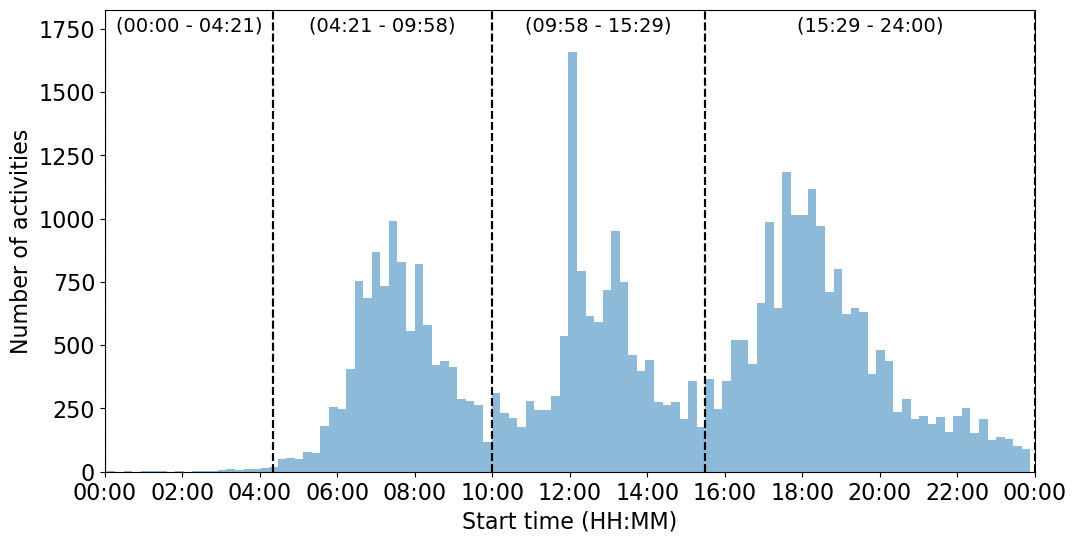

In [18]:
# Visualisation of the method 2
interval_duration, interval_bounds = plot_activity_intervals(bin=108, order=10, 
                                                             tim=timings[(timings['emp']==1) & (timings['day']<=5)], th=1, plot=True)

In [19]:
# Method 2: histogramm wd
df_full_2_wd, interval_bounds_all_2_wd = assign_slots(df_interval=timings, df_full=tim_full[tim_full['day']<6], 
                                                num_inter=0, defined=None)

#df_full_2_wd.to_csv('slots_histo_wd.csv', index=False)

In [20]:
# Method 2: histogramm we
df_full_2_we, interval_bounds_all_2_we = assign_slots(df_interval=timings, df_full=tim_full[tim_full['day']>=6], 
                                                num_inter=0, defined=None)

#df_full_2_we.to_csv('slots_histo_we.csv', index=False)

### 4.3 METHOD 3: DEFINED TIME SLOTS DURATION

In [21]:
# Method 3: defined nb inter
df_full_3, interval_bounds_all_3 = assign_slots(df_interval=timings, df_full=tim_full, num_inter=24, defined=None)

#df_full_3.to_csv('slots_nb_inter_24.csv', index=False)

## 5. OUTPUT AND MOST COMMON MOTIF

### 5.1 METHOD 1

In [28]:
%%time
most_def_wd, most_def_we, inter_def_wd, inter_def_we = get_most_general(df_interval=timings, df_full=tim_full, num_inter=2,
                                                                        defined_wd=def_inter_wd, defined_we=def_inter_we)

CPU times: total: 13.2 s
Wall time: 13.4 s


#### Weekdays

In [29]:
print(output_most_act(most_def_wd, 3, inter_def_wd))

Activity for emp 1, slot 1 (00:00-05:00): 0 (98.09 % [10762]); 2 (1.8 % [198]); 6 (0.06 % [7]) 
Activity for emp 1, slot 2 (05:00-11:30): 0 (49.81 % [11211]); 2 (36.86 % [8295]); 6 (4.64 % [1045]) 
Activity for emp 1, slot 3 (11:30-13:30): 2 (55.82 % [9350]); 0 (22.09 % [3701]); 8 (10.02 % [1678]) 
Activity for emp 1, slot 4 (13:30-16:30): 2 (52.92 % [7598]); 0 (23.88 % [3429]); 8 (6.9 % [991]) 
Activity for emp 1, slot 5 (16:30-18:00): 2 (40.21 % [5841]); 0 (39.13 % [5684]); 8 (6.79 % [986]) 
Activity for emp 1, slot 6 (18:00-24:00): 0 (65.43 % [12234]); 8 (14.59 % [2727]); 2 (11.94 % [2232]) 

Principal motif for emp 1: 0, 2, 0 

Activity for emp 2, slot 1 (00:00-05:00): 0 (99.4 % [6128]); 2 (0.49 % [30]); 6 (0.06 % [4]) 
Activity for emp 2, slot 2 (05:00-11:30): 0 (57.27 % [7729]); 2 (21.36 % [2883]); 4 (8.4 % [1134]) 
Activity for emp 2, slot 3 (11:30-13:30): 0 (43.8 % [3794]); 2 (34.6 % [2997]); 8 (10.02 % [868]) 
Activity for emp 2, slot 4 (13:30-16:30): 0 (44.92 % [4406]); 2 (23

#### Weekend

In [30]:
print(output_most_act(most_def_we, 3, inter_def_we))

Activity for emp 1, slot 1 (00:00-07:30): 0 (93.55 % [3406]); 2 (4.78 % [174]); 8 (0.8 % [29]) 
Activity for emp 1, slot 2 (07:30-13:00): 0 (61.61 % [4258]); 8 (17.87 % [1235]); 4 (9.87 % [682]) 
Activity for emp 1, slot 3 (13:00-18:00): 0 (55.76 % [3652]); 8 (27.89 % [1827]); 4 (6.66 % [436]) 
Activity for emp 1, slot 4 (18:00-20:00): 0 (71.1 % [2812]); 8 (21.44 % [848]); 2 (4.8 % [190]) 
Activity for emp 1, slot 5 (20:00-24:00): 0 (79.34 % [3218]); 8 (16.59 % [673]); 2 (2.91 % [118]) 

Principal motif for emp 1: 0 

Activity for emp 2, slot 1 (00:00-07:30): 0 (94.6 % [1927]); 2 (4.37 % [89]); 8 (0.54 % [11]) 
Activity for emp 2, slot 2 (07:30-13:00): 0 (62.46 % [2452]); 8 (17.58 % [690]); 4 (10.39 % [408]) 
Activity for emp 2, slot 3 (13:00-18:00): 0 (56.36 % [2068]); 8 (27.12 % [995]); 4 (6.6 % [242]) 
Activity for emp 2, slot 4 (18:00-20:00): 0 (71.18 % [1608]); 8 (21.65 % [489]); 2 (4.47 % [101]) 
Activity for emp 2, slot 5 (20:00-24:00): 0 (80.54 % [1842]); 8 (15.48 % [354]); 2 (

### 5.2 METHOD 2

In [22]:
%%time
most_wd, most_we, inter_wd, inter_we = get_most_general(df_interval=timings, df_full=tim_full, num_inter=0)

CPU times: total: 13 s
Wall time: 13.6 s


#### Weekdays

In [26]:
print(output_most_act(most_wd, 3, inter_wd))

Activity for emp 1, slot 1 (00:00-04:21): 0 (99.18 % [10762]); 2 (0.77 % [84]); 6 (0.04 % [4]) 
Activity for emp 1, slot 2 (04:21-09:58): 0 (52.11 % [11036]); 2 (37.73 % [7991]); 6 (4.2 % [889]) 
Activity for emp 1, slot 3 (09:58-15:29): 2 (49.64 % [10919]); 0 (23.82 % [5240]); 8 (9.76 % [2147]) 
Activity for emp 1, slot 4 (15:29-24:00): 0 (48.51 % [13619]); 2 (26.31 % [7386]); 8 (11.78 % [3308]) 

Principal motif for emp 1: 0, 2, 0 

Activity for emp 2, slot 1 (00:00-05:36): 0 (99.03 % [6132]); 2 (0.79 % [49]); 6 (0.08 % [5]) 
Activity for emp 2, slot 2 (05:36-10:28): 0 (57.97 % [6980]); 2 (23.01 % [2770]); 4 (7.14 % [860]) 
Activity for emp 2, slot 3 (10:28-16:28): 0 (40.33 % [6060]); 2 (25.83 % [3882]); 8 (12.14 % [1825]) 
Activity for emp 2, slot 4 (16:28-24:00): 0 (58.38 % [7791]); 2 (14.61 % [1950]); 8 (13.97 % [1864]) 

Principal motif for emp 2: 0 

Activity for emp 3, slot 1 (00:00-06:18): 0 (99.52 % [6061]); 2 (0.41 % [25]); 3 (0.03 % [2]) 
Activity for emp 3, slot 2 (06:18-1

#### Weekend

In [27]:
print(output_most_act(most_we, 3, inter_we))

Activity for emp 1, slot 1 (00:00-07:52): 0 (91.64 % [3429]); 2 (5.42 % [203]); 8 (1.31 % [49]) 
Activity for emp 1, slot 2 (07:52-12:59): 0 (61.57 % [4219]); 8 (18.01 % [1234]); 4 (9.84 % [674]) 
Activity for emp 1, slot 3 (12:59-24:00): 0 (59.21 % [5251]); 8 (26.77 % [2374]); 4 (5.38 % [477]) 

Principal motif for emp 1: 0 

Activity for emp 2, slot 1 (00:00-07:55): 0 (92.75 % [1931]); 2 (5.09 % [106]); 8 (0.96 % [20]) 
Activity for emp 2, slot 2 (07:55-12:44): 0 (62.57 % [2399]); 8 (17.4 % [667]); 4 (10.49 % [402]) 
Activity for emp 2, slot 3 (12:44-24:00): 0 (59.92 % [2961]); 8 (25.68 % [1269]); 4 (5.63 % [278]) 

Principal motif for emp 2: 0 

Activity for emp 3, slot 1 (00:00-09:51): 0 (84.44 % [1747]); 8 (9.71 % [201]); 2 (2.08 % [43]) 
Activity for emp 3, slot 2 (09:51-14:57): 0 (55.26 % [1861]); 8 (33.22 % [1119]); 4 (6.41 % [216]) 
Activity for emp 3, slot 3 (14:57-22:56): 0 (56.32 % [2188]); 8 (36.34 % [1412]); 4 (3.37 % [131]) 
Activity for emp 3, slot 4 (22:56-24:00): 0 (8

### 5.3 METHOD 3

### 1440 time slots (1 min)

In [31]:
%%time
most_wd_1440, most_we_1440, inter_wd_1440, inter_we_1440 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=1440)

CPU times: total: 2min 23s
Wall time: 2min 24s


#### Weekdays

In [32]:
print(output_most_act(most_wd_1440, 3, inter_wd_1440))

Activity for emp 1, slot 1 (00:00-00:01): 0 (100.0 % [10760]) 
Activity for emp 1, slot 2 (00:01-00:02): 0 (100.0 % [10760]) 
Activity for emp 1, slot 3 (00:02-00:03): 0 (100.0 % [10760]) 
Activity for emp 1, slot 4 (00:03-00:04): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 5 (00:04-00:05): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 6 (00:05-00:06): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 7 (00:06-00:07): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 8 (00:07-00:08): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 9 (00:08-00:09): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 10 (00:09-00:10): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 11 (00:10-00:11): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 12 (00:11-00:12): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 13 (00:12-00:13): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 

#### Weekend

In [33]:
print(output_most_act(most_we_1440, 3, inter_we_1440))

Activity for emp 1, slot 1 (00:00-00:01): 0 (100.0 % [3381]) 
Activity for emp 1, slot 2 (00:01-00:02): 0 (100.0 % [3381]) 
Activity for emp 1, slot 3 (00:02-00:03): 0 (100.0 % [3381]) 
Activity for emp 1, slot 4 (00:03-00:04): 0 (100.0 % [3381]) 
Activity for emp 1, slot 5 (00:04-00:05): 0 (100.0 % [3381]) 
Activity for emp 1, slot 6 (00:05-00:06): 0 (100.0 % [3381]) 
Activity for emp 1, slot 7 (00:06-00:07): 0 (100.0 % [3381]) 
Activity for emp 1, slot 8 (00:07-00:08): 0 (100.0 % [3381]) 
Activity for emp 1, slot 9 (00:08-00:09): 0 (100.0 % [3381]) 
Activity for emp 1, slot 10 (00:09-00:10): 0 (100.0 % [3381]) 
Activity for emp 1, slot 11 (00:10-00:11): 0 (100.0 % [3381]) 
Activity for emp 1, slot 12 (00:11-00:12): 0 (100.0 % [3381]) 
Activity for emp 1, slot 13 (00:12-00:13): 0 (100.0 % [3381]) 
Activity for emp 1, slot 14 (00:13-00:14): 0 (100.0 % [3381]) 
Activity for emp 1, slot 15 (00:14-00:15): 0 (100.0 % [3381]) 
Activity for emp 1, slot 16 (00:15-00:16): 0 (100.0 % [3381]) 
A

### 288 time slots (5 min)

In [34]:
%%time
most_wd_288, most_we_288, inter_wd_288, inter_we_288 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=288)

CPU times: total: 35.7 s
Wall time: 35.9 s


#### Weekdays

In [35]:
print(output_most_act(most_wd_288, 3, inter_wd_288))

Activity for emp 1, slot 1 (00:00-00:05): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 2 (00:05-00:10): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 3 (00:10-00:15): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 4 (00:15-00:20): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 5 (00:20-00:25): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 6 (00:25-00:30): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 7 (00:30-00:35): 0 (99.99 % [10757]); 2 (0.01 % [1]) 
Activity for emp 1, slot 8 (00:35-00:40): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 9 (00:40-00:45): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 10 (00:45-00:50): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 11 (00:50-00:55): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 12 (00:55-01:00): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 13 (01:00-01:05): 0 (99.

#### Weekend

In [36]:
print(output_most_act(most_we_288, 3, inter_we_288))

Activity for emp 1, slot 1 (00:00-00:05): 0 (100.0 % [3381]) 
Activity for emp 1, slot 2 (00:05-00:10): 0 (100.0 % [3381]) 
Activity for emp 1, slot 3 (00:10-00:15): 0 (100.0 % [3381]) 
Activity for emp 1, slot 4 (00:15-00:20): 0 (100.0 % [3381]) 
Activity for emp 1, slot 5 (00:20-00:25): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 6 (00:25-00:30): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 7 (00:30-00:35): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 8 (00:35-00:40): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 9 (00:40-00:45): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 10 (00:45-00:50): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 11 (00:50-00:55): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 12 (00:55-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 13 (01:00-01:05): 0 (99.97 % [3380]); 2 (0.03 % [1]) 
Activity for emp 1, slot 14 (01:05-01:10): 0 (

### 144 time slots (10 min)

In [37]:
%%time
most_wd_144, most_we_144, inter_wd_144, inter_we_144 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=144)

CPU times: total: 23.7 s
Wall time: 23.8 s


#### Weekdays

In [38]:
print(output_most_act(most_wd_144, 3, inter_wd_144))

Activity for emp 1, slot 1 (00:00-00:10): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 2 (00:10-00:20): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 3 (00:20-00:30): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 4 (00:30-00:40): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 5 (00:40-00:50): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 6 (00:50-01:00): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 7 (01:00-01:10): 0 (99.97 % [10754]); 2 (0.03 % [3]) 
Activity for emp 1, slot 8 (01:10-01:20): 0 (99.94 % [10753]); 2 (0.05 % [5]); 6 (0.01 % [1]) 
Activity for emp 1, slot 9 (01:20-01:30): 0 (99.93 % [10753]); 2 (0.06 % [6]); 6 (0.01 % [1]) 
Activity for emp 1, slot 10 (01:30-01:40): 0 (99.91 % [10749]); 2 (0.08 % [9]); 6 (0.01 % [1]) 
Activity for emp 1, slot 11 (01:40-01:50): 0 (99.91 % [10748]); 2 (0.08 % [9]); 6 (0.01 % [1]) 
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.89 % [10748]); 2

#### Weekend

In [39]:
print(output_most_act(most_we_144, 3, inter_we_144))

Activity for emp 1, slot 1 (00:00-00:10): 0 (100.0 % [3381]) 
Activity for emp 1, slot 2 (00:10-00:20): 0 (100.0 % [3381]) 
Activity for emp 1, slot 3 (00:20-00:30): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 4 (00:30-00:40): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 5 (00:40-00:50): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 6 (00:50-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 7 (01:00-01:10): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 8 (01:10-01:20): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 9 (01:20-01:30): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 10 (01:30-01:40): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 11 (01:40-01:50): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 12 (01:50-02:00): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]

### 96 time slots (15 min)

In [40]:
%%time
most_wd_96, most_we_96, inter_wd_96, inter_we_96 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=96)

CPU times: total: 21.1 s
Wall time: 21.4 s


#### Weekdays

In [41]:
print(output_most_act(most_wd_96, 3, inter_wd_96))

Activity for emp 1, slot 1 (00:00-00:15): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 2 (00:15-00:30): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 3 (00:30-00:45): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 4 (00:45-01:00): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 5 (01:00-01:15): 0 (99.96 % [10754]); 2 (0.03 % [3]); 6 (0.01 % [1]) 
Activity for emp 1, slot 6 (01:15-01:30): 0 (99.93 % [10753]); 2 (0.06 % [6]); 6 (0.01 % [1]) 
Activity for emp 1, slot 7 (01:30-01:45): 0 (99.91 % [10749]); 2 (0.08 % [9]); 6 (0.01 % [1]) 
Activity for emp 1, slot 8 (01:45-02:00): 0 (99.89 % [10748]); 2 (0.1 % [11]); 6 (0.01 % [1]) 
Activity for emp 1, slot 9 (02:00-02:15): 0 (99.87 % [10745]); 2 (0.12 % [13]); 6 (0.01 % [1]) 
Activity for emp 1, slot 10 (02:15-02:30): 0 (99.85 % [10743]); 2 (0.14 % [15]); 6 (0.01 % [1]) 
Activity for emp 1, slot 11 (02:30-02:45): 0 (99.84 % [10736]); 2 (0.15 % [16]); 6 (0.01 % [1]) 
Activity for e

#### Weekend

In [42]:
print(output_most_act(most_we_96, 3, inter_we_96))

Activity for emp 1, slot 1 (00:00-00:15): 0 (100.0 % [3381]) 
Activity for emp 1, slot 2 (00:15-00:30): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 3 (00:30-00:45): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 4 (00:45-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 5 (01:00-01:15): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 6 (01:15-01:30): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 7 (01:30-01:45): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 8 (01:45-02:00): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 9 (02:00-02:15): 0 (99.88 % [3377]); 2 (0.06 % [2]); 8 (0.03 % [1]) 
Activity for emp 1, slot 10 (02:15-02:30): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1]) 
Activity for emp 1, slot 11 (02:30-02:45): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1]) 
Activity for emp 1, slot 12 (02:45-03:00): 0

### 48 time slots (30 min)

In [43]:
%%time
most_wd_48, most_we_48, inter_wd_48, inter_we_48 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=48)

CPU times: total: 15.3 s
Wall time: 15.3 s


#### Weekdays

In [44]:
print(output_most_act(most_wd_48, 3, inter_wd_48))

Activity for emp 1, slot 1 (00:00-00:30): 0 (99.99 % [10760]); 2 (0.01 % [1]) 
Activity for emp 1, slot 2 (00:30-01:00): 0 (99.98 % [10757]); 2 (0.02 % [2]) 
Activity for emp 1, slot 3 (01:00-01:30): 0 (99.93 % [10754]); 2 (0.06 % [6]); 6 (0.01 % [1]) 
Activity for emp 1, slot 4 (01:30-02:00): 0 (99.89 % [10749]); 2 (0.1 % [11]); 6 (0.01 % [1]) 
Activity for emp 1, slot 5 (02:00-02:30): 0 (99.85 % [10745]); 2 (0.14 % [15]); 6 (0.01 % [1]) 
Activity for emp 1, slot 6 (02:30-03:00): 0 (99.8 % [10736]); 2 (0.19 % [20]); 6 (0.01 % [1]) 
Activity for emp 1, slot 7 (03:00-03:30): 0 (99.67 % [10718]); 2 (0.31 % [33]); 6 (0.02 % [2]) 
Activity for emp 1, slot 8 (03:30-04:00): 0 (99.47 % [10696]); 2 (0.5 % [54]); 6 (0.02 % [2]) 
Activity for emp 1, slot 9 (04:00-04:30): 0 (99.16 % [10656]); 2 (0.79 % [85]); 6 (0.04 % [4]) 
Activity for emp 1, slot 10 (04:30-05:00): 0 (98.08 % [10529]); 2 (1.81 % [194]); 6 (0.07 % [7]) 
Activity for emp 1, slot 11 (05:00-05:30): 0 (96.72 % [10347]); 2 (3.08 % [3

#### Weekend

In [45]:
print(output_most_act(most_we_48, 3, inter_we_48))

Activity for emp 1, slot 1 (00:00-00:30): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 2 (00:30-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 3 (01:00-01:30): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 4 (01:30-02:00): 0 (99.94 % [3379]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 5 (02:00-02:30): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1]) 
Activity for emp 1, slot 6 (02:30-03:00): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1]) 
Activity for emp 1, slot 7 (03:00-03:30): 0 (99.82 % [3375]); 2 (0.12 % [4]); 8 (0.03 % [1]) 
Activity for emp 1, slot 8 (03:30-04:00): 0 (99.65 % [3370]); 2 (0.3 % [10]); 8 (0.03 % [1]) 
Activity for emp 1, slot 9 (04:00-04:30): 0 (99.47 % [3361]); 2 (0.44 % [15]); 6 (0.03 % [1]) 
Activity for emp 1, slot 10 (04:30-05:00): 0 (99.17 % [3352]); 2 (0.77 % [26]); 8 (0.03 % [1]) 
Activity for emp 1, slot 11 (05:00-05:30): 0 (98.87 % [3338]); 2 (0.95 % [32]); 8 (0.09 %

### 24 time slots (1 hour)

In [46]:
%%time
most_wd_24, most_we_24, inter_wd_24, inter_we_24 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=24)

CPU times: total: 13.1 s
Wall time: 13.1 s


#### Weekdays

In [47]:
print(output_most_act(most_wd_24, 3, inter_wd_24))

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.98 % [10760]); 2 (0.02 % [2]) 
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.89 % [10754]); 2 (0.1 % [11]); 6 (0.01 % [1]) 
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.8 % [10745]); 2 (0.19 % [20]); 6 (0.01 % [1]) 
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.46 % [10720]); 2 (0.51 % [55]); 6 (0.02 % [2]) 
Activity for emp 1, slot 5 (04:00-05:00): 0 (98.09 % [10656]); 2 (1.8 % [195]); 6 (0.06 % [7]) 
Activity for emp 1, slot 6 (05:00-06:00): 0 (93.4 % [10349]); 2 (6.18 % [685]); 6 (0.18 % [20]) 
Activity for emp 1, slot 7 (06:00-07:00): 0 (73.92 % [8879]); 2 (23.93 % [2874]); 6 (1.04 % [125]) 
Activity for emp 1, slot 8 (07:00-08:00): 2 (48.56 % [5818]); 0 (44.87 % [5376]); 6 (3.76 % [450]) 
Activity for emp 1, slot 9 (08:00-09:00): 2 (63.5 % [7146]); 0 (25.1 % [2825]); 6 (5.93 % [667]) 
Activity for emp 1, slot 10 (09:00-10:00): 2 (67.22 % [7444]); 0 (18.53 % [2052]); 6 (6.95 % [770]) 
Activity for emp 1, slot 11 (10:00-11:00): 

#### Weekend

In [48]:
print(output_most_act(most_we_24, 3, inter_we_24))

Activity for emp 1, slot 1 (00:00-01:00): 0 (99.97 % [3381]); 2 (0.03 % [1]) 
Activity for emp 1, slot 2 (01:00-02:00): 0 (99.94 % [3380]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 3 (02:00-03:00): 0 (99.85 % [3377]); 2 (0.09 % [3]); 8 (0.03 % [1]) 
Activity for emp 1, slot 4 (03:00-04:00): 0 (99.62 % [3375]); 2 (0.32 % [11]); 8 (0.03 % [1]) 
Activity for emp 1, slot 5 (04:00-05:00): 0 (99.12 % [3361]); 2 (0.8 % [27]); 6 (0.03 % [1]) 
Activity for emp 1, slot 6 (05:00-06:00): 0 (97.95 % [3340]); 2 (1.79 % [61]); 8 (0.18 % [6]) 
Activity for emp 1, slot 7 (06:00-07:00): 0 (95.38 % [3262]); 2 (3.71 % [127]); 8 (0.5 % [17]) 
Activity for emp 1, slot 8 (07:00-08:00): 0 (91.05 % [3153]); 2 (5.75 % [199]); 8 (1.39 % [48]) 
Activity for emp 1, slot 9 (08:00-09:00): 0 (83.2 % [2921]); 2 (7.63 % [268]); 8 (4.27 % [150]) 
Activity for emp 1, slot 10 (09:00-10:00): 0 (72.18 % [2566]); 8 (9.79 % [348]); 2 (8.72 % [310]) 
Activity for emp 1, slot 11 (10:00-11:00): 0 (61.45 % [2197])

### 12 time slots (2 hours)

In [49]:
%%time
most_wd_12, most_we_12, inter_wd_12, inter_we_12 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=12)

CPU times: total: 12.8 s
Wall time: 12.9 s


#### Weekdays

In [50]:
print(output_most_act(most_wd_12, 3, inter_wd_12))

Activity for emp 1, slot 1 (00:00-02:00): 0 (99.89 % [10760]); 2 (0.1 % [11]); 6 (0.01 % [1]) 
Activity for emp 1, slot 2 (02:00-04:00): 0 (99.46 % [10747]); 2 (0.51 % [55]); 6 (0.02 % [2]) 
Activity for emp 1, slot 3 (04:00-06:00): 0 (93.54 % [10660]); 2 (6.05 % [690]); 6 (0.18 % [20]) 
Activity for emp 1, slot 4 (06:00-08:00): 0 (56.84 % [8948]); 2 (37.7 % [5934]); 6 (2.95 % [465]) 
Activity for emp 1, slot 5 (08:00-10:00): 2 (60.79 % [7603]); 0 (24.03 % [3006]); 6 (6.68 % [836]) 
Activity for emp 1, slot 6 (10:00-12:00): 2 (61.21 % [7710]); 0 (18.97 % [2390]); 6 (6.98 % [879]) 
Activity for emp 1, slot 7 (12:00-14:00): 2 (52.64 % [8075]); 0 (24.01 % [3684]); 8 (11.18 % [1715]) 
Activity for emp 1, slot 8 (14:00-16:00): 2 (58.63 % [7308]); 0 (20.76 % [2588]); 6 (6.96 % [868]) 
Activity for emp 1, slot 9 (16:00-18:00): 2 (41.37 % [6551]); 0 (36.8 % [5828]); 8 (6.81 % [1079]) 
Activity for emp 1, slot 10 (18:00-20:00): 0 (61.27 % [9139]); 8 (14.97 % [2233]); 2 (14.45 % [2155]) 
Activit

#### Weekend

In [51]:
print(output_most_act(most_we_12, 3, inter_we_12))

Activity for emp 1, slot 1 (00:00-02:00): 0 (99.94 % [3381]); 8 (0.03 % [1]); 2 (0.03 % [1]) 
Activity for emp 1, slot 2 (02:00-04:00): 0 (99.62 % [3377]); 2 (0.32 % [11]); 8 (0.03 % [1]) 
Activity for emp 1, slot 3 (04:00-06:00): 0 (97.88 % [3363]); 2 (1.83 % [63]); 8 (0.17 % [6]) 
Activity for emp 1, slot 4 (06:00-08:00): 0 (91.26 % [3300]); 2 (5.56 % [201]); 8 (1.36 % [49]) 
Activity for emp 1, slot 5 (08:00-10:00): 0 (73.83 % [3084]); 8 (9.05 % [378]); 2 (7.68 % [321]) 
Activity for emp 1, slot 6 (10:00-12:00): 0 (56.76 % [2545]); 8 (20.16 % [904]); 4 (10.04 % [450]) 
Activity for emp 1, slot 7 (12:00-14:00): 0 (55.78 % [2284]); 8 (26.69 % [1093]); 2 (7.64 % [313]) 
Activity for emp 1, slot 8 (14:00-16:00): 0 (52.74 % [2236]); 8 (30.94 % [1312]); 2 (6.49 % [275]) 
Activity for emp 1, slot 9 (16:00-18:00): 0 (60.82 % [2599]); 8 (26.28 % [1123]); 2 (6.11 % [261]) 
Activity for emp 1, slot 10 (18:00-20:00): 0 (71.1 % [2812]); 8 (21.44 % [848]); 2 (4.8 % [190]) 
Activity for emp 1, slo

### 4 time slots (6 hours)

In [52]:
%%time
most_wd_4, most_we_4, inter_wd_4, inter_we_4 = get_most_general(df_interval=timings, df_full=tim_full, num_inter=4)

CPU times: total: 11.6 s
Wall time: 11.6 s


#### Weekdays

In [53]:
print(output_most_act(most_wd_4, 3, inter_wd_4))

Activity for emp 1, slot 1 (00:00-06:00): 0 (93.58 % [10766]); 2 (6.02 % [693]); 6 (0.17 % [20]) 
Activity for emp 1, slot 2 (06:00-12:00): 0 (46.02 % [10100]); 2 (38.26 % [8398]); 6 (4.88 % [1072]) 
Activity for emp 1, slot 3 (12:00-18:00): 2 (36.62 % [8928]); 0 (35.19 % [8580]); 8 (11.11 % [2708]) 
Activity for emp 1, slot 4 (18:00-24:00): 0 (65.43 % [12234]); 8 (14.59 % [2727]); 2 (11.94 % [2232]) 

Principal motif for emp 1: 0, 2, 0 

Activity for emp 2, slot 1 (00:00-06:00): 0 (98.18 % [6133]); 2 (1.54 % [96]); 8 (0.14 % [9]) 
Activity for emp 2, slot 2 (06:00-12:00): 0 (56.76 % [8001]); 2 (20.78 % [2929]); 4 (8.65 % [1219]) 
Activity for emp 2, slot 3 (12:00-18:00): 0 (47.08 % [7079]); 2 (20.2 % [3038]); 8 (12.43 % [1869]) 
Activity for emp 2, slot 4 (18:00-24:00): 0 (70.49 % [6890]); 8 (13.92 % [1361]); 2 (8.15 % [797]) 

Principal motif for emp 2: 0 

Activity for emp 3, slot 1 (00:00-06:00): 0 (99.74 % [6059]); 2 (0.23 % [14]); 8 (0.02 % [1]) 
Activity for emp 3, slot 2 (06:00

#### Weekend

In [54]:
print(output_most_act(most_we_4, 3, inter_we_4))

Activity for emp 1, slot 1 (00:00-06:00): 0 (97.83 % [3383]); 2 (1.88 % [65]); 8 (0.17 % [6]) 
Activity for emp 1, slot 2 (06:00-12:00): 0 (64.27 % [4163]); 8 (15.49 % [1003]); 4 (9.36 % [606]) 
Activity for emp 1, slot 3 (12:00-18:00): 0 (55.15 % [3953]); 8 (27.2 % [1950]); 4 (7.65 % [548]) 
Activity for emp 1, slot 4 (18:00-24:00): 0 (72.62 % [3548]); 8 (20.59 % [1006]); 2 (4.15 % [203]) 

Principal motif for emp 1: 0 

Activity for emp 2, slot 1 (00:00-06:00): 0 (98.87 % [1922]); 2 (0.98 % [19]); 6 (0.1 % [2]) 
Activity for emp 2, slot 2 (06:00-12:00): 0 (65.28 % [2390]); 8 (15.57 % [570]); 4 (9.78 % [358]) 
Activity for emp 2, slot 3 (12:00-18:00): 0 (55.38 % [2240]); 8 (26.6 % [1076]); 4 (7.56 % [306]) 
Activity for emp 2, slot 4 (18:00-24:00): 0 (73.28 % [2010]); 8 (19.98 % [548]); 2 (3.86 % [106]) 

Principal motif for emp 2: 0 

Activity for emp 3, slot 1 (00:00-06:00): 0 (99.83 % [1717]); 8 (0.06 % [1]); 2 (0.06 % [1]) 
Activity for emp 3, slot 2 (06:00-12:00): 0 (71.46 % [188